### Scope: The players roughly approximate all players that would be owned in a 12-team league, hold for some very-deep sleepers. The counts are shown below:
`[('QB', 50), ('RB', 100), ('WR', 150), ('TE', 30), ('D/ST', 32), ('K', 40)]`<br><br>
More details can be found in the `download_projection_data` notebook. 

# Part 1: Mean Absolute Deviation (MAD)
## a) All players

In [1]:
import json
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

with open('projections_thru_wk_13_ppr.json', 'r') as f:
    jsons = json.load(f)

In [2]:
recs = pd.DataFrame(jsons)
recs.shape

(5226, 5)

In [3]:
recs.head()

,name,points,projected,position,week
0,Patrick Mahomes,20.44,23.31,QB,1
1,Russell Wilson,31.78,19.81,QB,1
2,Kyler Murray,26.30,18.00,QB,1
3,Josh Allen,28.18,19.84,QB,1
4,Deshaun Watson,20.82,21.95,QB,1


In [4]:
recs = recs.loc[recs['projected'] >= 1.0].copy()
recs.shape

(3703, 5)

### Are these projections accurate on average?

In [5]:
recs['prmp'] = recs['projected'] - recs['points']
recs['mae'] = recs['prmp'].abs()

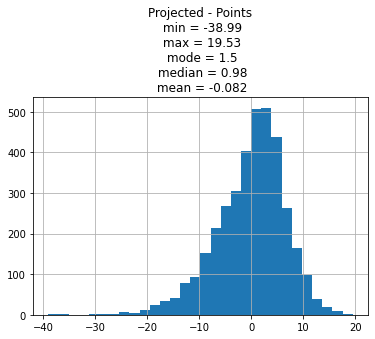

In [6]:
recs.prmp.hist(bins=30)
plt.title('Projected - Points\n min = {}\n max = {}\n mode = {}\n median = {}\n mean = {}'.format(np.round(recs.prmp.min(), 3), np.round(recs.prmp.max(), 3), np.round(recs.prmp.mode()[0], 3), np.round(recs.prmp.median(), 3), np.round(recs.prmp.mean(), 3)))
plt.show()

### Are these projections precise on average using bootstrap as a test for statistical significance
inspired by https://datascopeanalytics.com/blog/are-espns-fantasy-football-projections-accurate/

In [7]:
rng = np.random.default_rng(seed=69)
N, n = 10000, len(recs)  # draw len(recs) independent samples with replacement 2000 times
X = recs.prmp.values
bs = rng.choice(X, replace=True, size = (N, n))
means_bs = bs.mean(axis=1)
meds_bs = np.median(bs, axis=1)

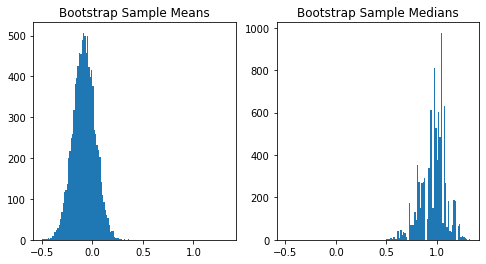

In [8]:
fig, axs = plt.subplots(1, 2, sharex=True, figsize=(8,4))
axs[0].hist(means_bs, bins='auto')
axs[0].set(title='Bootstrap Sample Means')
axs[1].hist(meds_bs, bins='auto')
axs[1].set(title='Bootstrap Sample Medians')
plt.show()

In [9]:
std_mean_bs = means_bs.std(ddof=1)
print('\nStandard error of mean:', std_mean_bs)
print('95% CI of mean samples: ', np.quantile(means_bs, [0.025, 0.975]))

std_med_bs = meds_bs.std(ddof=1)
print('\nStandard error of median:', std_med_bs)
print('95% CI of median samples: ', np.quantile(meds_bs, [0.025, 0.975]))


Standard error of mean: 0.10923093150372948
95% CI of mean samples:  [-0.29639373  0.13287935]

Standard error of median: 0.12077946293913873
95% CI of median samples:  [0.72 1.19]


Observations
- The mean contains zero however as noted above there is a left skew where ESPN severely underprojects, so we will interpret the median bootstrap
- According to our bootstrap analysis, the sampling distribution, and 95% CI, of the median shown above does not zero and by that account we can say the projections are different from zero.

### Using projections for start/sit decisions

In [10]:
def find_nearest_argmin(array, value):
    array = np.array(array)
    idx = (np.abs(array - value)).argmin()
    return idx

In [11]:
check = [-20, -10, -5, -3, -2, -1, 0, 1, 2, 3, 5, 10, 20]
density = []

def proj(i):
    return 'underprojects' if i < 0 else 'overprojects'

for i in range(1, len(check)):
    val = (find_nearest_argmin(recs.prmp.sort_values().values, check[i]) \
     - find_nearest_argmin(recs.prmp.sort_values().values, check[i-1]))/len(recs.prmp)
    density.append(val)
    print('ESPN {} between {} and {} {}% of the time'.format(proj(check[i-1]), check[i-1], check[i], np.round(val*100, 2)))
print('total distribution covered: {}%'.format(np.round(sum(density), 4)*100))
left, right = -3, 3
print('\nmass between {} and {} {}%'.format(left, right, np.round(sum(density[check.index(left):check.index(right)])*100,2)))
print('\nOverall, ESPN underprojects {}% of the time'.format(np.round(sum(density[check.index(-20):check.index(0)])*100,2)))
print('Overall, ESPN overprojects {}% of the time'.format(np.round(sum(density[check.index(0):check.index(20)])*100,2)))

ESPN underprojects between -20 and -10 7.1% of the time
ESPN underprojects between -10 and -5 12.99% of the time
ESPN underprojects between -5 and -3 7.72% of the time
ESPN underprojects between -3 and -2 4.54% of the time
ESPN underprojects between -2 and -1 5.59% of the time
ESPN underprojects between -1 and 0 5.64% of the time
ESPN overprojects between 0 and 1 5.64% of the time
ESPN overprojects between 1 and 2 8.32% of the time
ESPN overprojects between 2 and 3 7.45% of the time
ESPN overprojects between 3 and 5 13.15% of the time
ESPN overprojects between 5 and 10 16.93% of the time
ESPN overprojects between 10 and 20 4.08% of the time
total distribution covered: 99.16%

mass between -3 and 3 37.19%

Overall, ESPN underprojects 43.59% of the time
Overall, ESPN overprojects 55.58% of the time


Observations
- As is consistent with the 2014 season analysis, ESPN overprojects, on average: https://datascopeanalytics.com/blog/are-espns-fantasy-football-projections-accurate/

## b) Starter Worthy
We will used point projections as a reasonable proxy for whether a player can expert to be started, broken down by position using my own subjective judgement. We will choose to exclude `D/ST` and `K` since the goodness of fit analysis seems to suggest projection data materially imprecise. 

In [12]:
recs = pd.DataFrame(jsons)
recs.shape

(5226, 5)

In [13]:
idxs = []
for k, v in [('QB', 10), ('RB', 5), ('WR', 8), ('TE', 5)]:
    hold = recs.loc[(recs['position'] == k) & (recs['projected'] >= v)]
    print('Approximate number of players per week for {}: {}, min: {}'.format(k, int(hold.groupby(by='week')['projected'].count().mean()), hold.groupby(by='week')['projected'].count().min()))
    idxs = idxs + list(hold.index.values)
len(idxs)

Approximate number of players per week for QB: 29, min: 27
Approximate number of players per week for RB: 54, min: 48
Approximate number of players per week for WR: 63, min: 58
Approximate number of players per week for TE: 21, min: 17


2188

These look solid.

In [14]:
recs = recs.iloc[idxs]
recs.shape

(2188, 5)

In [15]:
recs['prmp'] = recs['projected'] - recs['points']
recs['mae'] = recs['prmp'].abs()

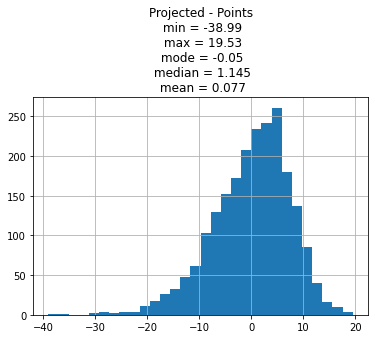

In [16]:
recs.prmp.hist(bins=30)
plt.title('Projected - Points\n min = {}\n max = {}\n mode = {}\n median = {}\n mean = {}'.format(np.round(recs.prmp.min(), 3), np.round(recs.prmp.max(), 3), np.round(recs.prmp.mode()[0], 3), np.round(recs.prmp.median(), 3), np.round(recs.prmp.mean(), 3)))
plt.show()

### Are these projections precise on average using bootstrap as a test for statistical significance
inspired by https://datascopeanalytics.com/blog/are-espns-fantasy-football-projections-accurate/

In [17]:
rng = np.random.default_rng(seed=69)
N, n = 10000, len(recs)  # draw len(recs) independent samples with replacement 2000 times
X = recs.prmp.values
bs = rng.choice(X, replace=True, size = (N, n))
means_bs = bs.mean(axis=1)
meds_bs = np.median(bs, axis=1)

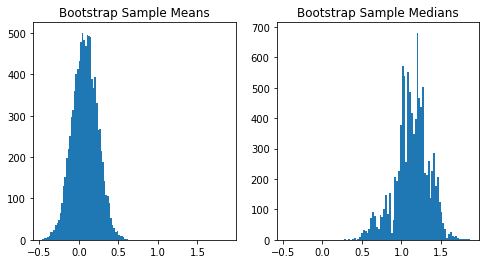

In [18]:
fig, axs = plt.subplots(1, 2, sharex=True, figsize=(8,4))
axs[0].hist(means_bs, bins='auto')
axs[0].set(title='Bootstrap Sample Means')
axs[1].hist(meds_bs, bins='auto')
axs[1].set(title='Bootstrap Sample Medians')
plt.show()

In [19]:
std_mean_bs = means_bs.std(ddof=1)
print('\nStandard error of mean:', std_mean_bs)
print('95% CI of mean samples: ', np.quantile(means_bs, [0.025, 0.975]))

std_med_bs = meds_bs.std(ddof=1)
print('\nStandard error of median:', std_med_bs)
print('95% CI of median samples: ', np.quantile(meds_bs, [0.025, 0.975]))


Standard error of mean: 0.15842248709568188
95% CI of mean samples:  [-0.22812729  0.38522166]

Standard error of median: 0.21415302048154294
95% CI of median samples:  [0.64 1.5 ]


Observations
- The mean contains zero however as noted above there is a left skew where ESPN severely underprojects, so we will interpret the median bootstrap
- According to our bootstrap analysis, the sampling distribution, and 95% CI, of the median shown above does not zero and by that account we can say the projections are different from zero.

### Using projections for start/sit decisions

In [20]:
def find_nearest_argmin(array, value):
    array = np.array(array)
    idx = (np.abs(array - value)).argmin()
    return idx

In [21]:
check = [-20, -10, -5, -3, -2, -1, 0, 1, 2, 3, 5, 10, 20]
density = []

def proj(i):
    return 'underprojects' if i < 0 else 'overprojects'

for i in range(1, len(check)):
    val = (find_nearest_argmin(recs.prmp.sort_values().values, check[i]) \
     - find_nearest_argmin(recs.prmp.sort_values().values, check[i-1]))/len(recs.prmp)
    density.append(val)
    print('ESPN {} between {} and {} {}% of the time'.format(proj(check[i-1]), check[i-1], check[i], np.round(val*100, 2)))
print('total distribution covered: {}%'.format(np.round(sum(density), 4)*100))
left, right = -3, 3
print('\nmass between {} and {} {}%'.format(left, right, np.round(sum(density[check.index(left):check.index(right)])*100,2)))
print('\nOverall, ESPN underprojects {}% of the time'.format(np.round(sum(density[check.index(-20):check.index(0)])*100,2)))
print('Overall, ESPN overprojects {}% of the time'.format(np.round(sum(density[check.index(0):check.index(20)])*100,2)))

ESPN underprojects between -20 and -10 8.32% of the time
ESPN underprojects between -10 and -5 13.89% of the time
ESPN underprojects between -5 and -3 7.36% of the time
ESPN underprojects between -3 and -2 4.3% of the time
ESPN underprojects between -2 and -1 4.89% of the time
ESPN underprojects between -1 and 0 4.75% of the time
ESPN overprojects between 0 and 1 4.48% of the time
ESPN overprojects between 1 and 2 6.49% of the time
ESPN overprojects between 2 and 3 5.67% of the time
ESPN overprojects between 3 and 5 12.16% of the time
ESPN overprojects between 5 and 10 20.25% of the time
ESPN overprojects between 10 and 20 6.31% of the time
total distribution covered: 98.86%

mass between -3 and 3 30.58%

Overall, ESPN underprojects 43.51% of the time
Overall, ESPN overprojects 55.35% of the time


### #TODOs

- Let's take this one step further and normalize the data to determine a percentage miss as inspired by this post https://datascopeanalytics.com/blog/are-espns-fantasy-football-projections-accurate/
- To assess whether projections can be used in start/sit decisions, I will test whether we perform better than an n-sided coin flip when we choose the highest projected player from a list of 2, 3, and 4 players. 

# Part 2: Goodness of fit analysis & Regression
Inspired by Steven Morse's Blog Post: Checking ESPN Fantasy Football Projections with Python<br>
https://stmorse.github.io/journal/espn-fantasy-projections.html

In [34]:
from sklearn.metrics import r2_score
from sklearn.linear_model import LinearRegression

$R^2$ from linear regression is the same as when it is derived from correlation

In [35]:
recs = pd.DataFrame(jsons)
recs = recs.loc[recs['projected'] >= 1.0].copy()
recs.shape

data = recs.loc[recs['position'] == 'K']
pts = data[['projected', 'points']].values
X = pts[:, 0].reshape(-1, 1)
y = pts[:, 1]
reg = LinearRegression().fit(X, y)
reg.score(X, y)
np.round(data[['projected', 'points']].corr().iloc[0, 1]**2, 10) == np.round(reg.score(X, y), 10), \
np.round(data[['projected', 'points']].corr().iloc[0, 1]**2, 10)

(True, 0.0132870993)

$\sqrt{R^2} = r_{xy} = \frac{Cov(X, Y)}{s_X s_y}$

In [36]:
# correlation is covariance normalized by the product of std_x and std_y
np.round((data[['projected', 'points']].cov().iloc[0, 1] / (data['projected'].std() * data['points'].std())), 10) \
    == np.round(data[['projected', 'points']].corr().iloc[0, 1], 10)\
    , np.round(data[['projected', 'points']].corr().iloc[0, 1], 10)

(True, 0.1152696808)

In [37]:
class Stats:
    """Used to check out work.
    Ref https://dziganto.github.io/data%20science/linear%20regression/machine%20learning/python/Linear-Regression-101-Metrics/"""
    
    def __init__(self, X, y, model):
        self.data = X
        self.target = y
        self.model = model
        ## degrees of freedom population dep. variable variance
        self._dft = X.shape[0] - 1   
        ## degrees of freedom population error variance
        self._dfe = X.shape[0] - X.shape[1] - 1  
    
    def sse(self):
        '''returns sum of squared errors (model vs actual)'''
        squared_errors = (self.target - self.model.predict(self.data)) ** 2
        return np.sum(squared_errors)
        
    def sst(self):
        '''returns total sum of squared errors (actual vs avg(actual))'''
        avg_y = np.mean(self.target)
        squared_errors = (self.target - avg_y) ** 2
        return np.sum(squared_errors)
    
    def r_squared(self):
        '''returns calculated value of r^2'''
        return 1 - self.sse()/self.sst()

$\hat{\beta}_1 = r \frac{s_Y}{s_X}$<br>
$R^2 = \frac{TSS - RSS}{TSS} =$ how much variation in y can be explained by variation in x <br>
$RSS = \sum_{i=1}^n e_i^2$ where $e_i = y_i - \hat{y_i}$ <br>
$TSS = \sigma^2 n$

In [38]:
print('R^2 via correlation', data[['projected', 'points']].corr().iloc[0, 1]**2)

R^2 via correlation 0.013287099301568205


In [39]:
rss = ((pts[:, 1] - pts[:, 0])**2).sum()
print('RSS for y hat = x:', rss)
print('RSS for y hat', Stats(X, y, reg).sse())

RSS for y hat = x: 7725.452
RSS for y hat 7671.690199466189


In [40]:
print('R^2 for y hat = x', 1 - rss/(pts[:, 1].var()*len(pts)))
print('R^2 for y hat', Stats(X, y, reg).r_squared())

R^2 for y hat = x 0.006372395921708129
R^2 for y hat 0.01328709930156824


According to KhanAcademy, "$R^2$ tells us what percent of the prediction error in the y variable is eliminated when we use least-squares regression on the x variable." Per the above, the $R^2$ depends on your definition of $\hat{y}$. Traditionally, $\hat{y_i}$ corresponds to the predicted value using the least squares estimate or the line that maximizes $R^2$. This is also the $\hat{y_i}$ you get when calculating $R^2$ with correlation. <br>

However for our problem, we are keen to know how well the data fits the true line, x=y since our x is trying to directly fit y. While this is not the least-squares regression, our non-OLS $R^2$ tells us what percent of the prediction error in the y variable is eliminated when we use the projections."

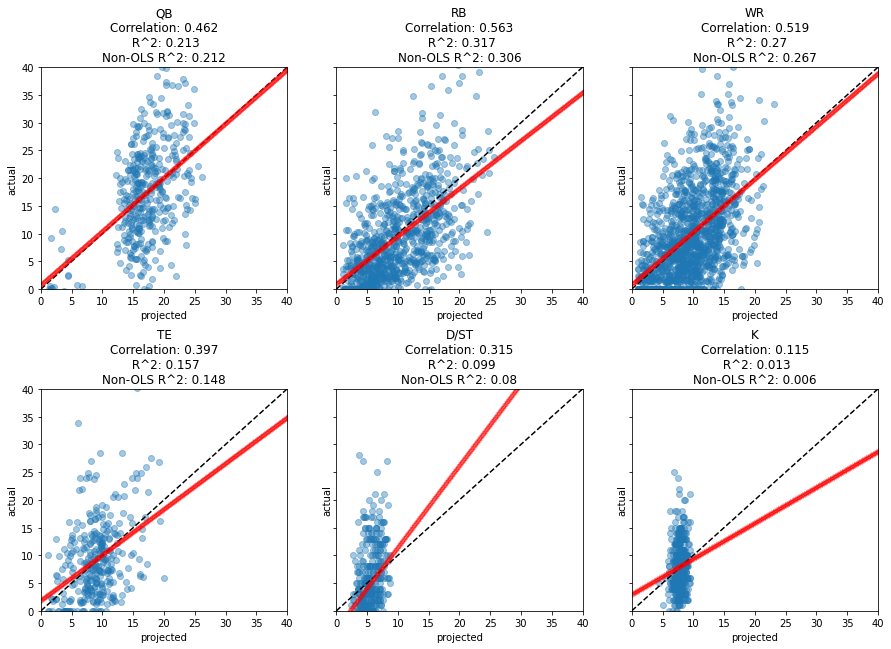

In [41]:
rows = 3
fig, axs = plt.subplots(2, rows, sharey=True, figsize=(15,10))
for i, p in enumerate(['QB', 'RB', 'WR', 'TE', 'D/ST', 'K']):
    data = recs.loc[recs['position'] == p]
    pts = data[['projected', 'points']].values
    r = data[['points', 'projected']].corr().iloc[0, 1]
    r2 = r ** 2
    y_hat_x = pts[:, 0]
    x_r2 = 1- ((pts[:, 1] - y_hat_x)**2).sum() / (pts[:, 1].var()*len(pts))
    X = pts[:, 0].reshape(-1, 1)
    y = pts[:, 1]
    reg = LinearRegression().fit(X, y)
    axs[i//rows][i%rows].plot(np.linspace(0, 50, 1000), np.linspace(0, 50, 1000), 'k--')
    axs[i//rows][i%rows].plot(np.linspace(0, 50, 1000), reg.predict(np.linspace(0, 50, 1000).reshape(-1, 1)), 'r+', alpha=0.25)
    axs[i//rows][i%rows].scatter(data['projected'], data['points'], alpha=0.4)
    axs[i//rows][i%rows].set(xlim=[0, 40], ylim=[0, 40], xlabel='projected', ylabel='actual', 
                             title='{}\nCorrelation: {}\n R^2: {}\nNon-OLS R^2: {}'.format(p, np.round(r, 3), np.round(r2, 3), np.round(x_r2, 3))
                            )
plt.subplots_adjust(hspace=0.45)
plt.show()

### Takeaways:
- QB projections are the strongest with around 54% of the variation in the actual value explained by the projection
  - This is likely explained by their comparatively lower actual score variance: QBs generally have a higher floor and lower ceiling and need to put up more stats for fewer points
- Prediction accuracy is mostly useless aside from being able to know that a player projected to score 20 will do better tha one projected to score 10
- Kicker projections are practially uncorrelated and by that metric, meaningless
- TE accuracy has the lowest $R^2$ of all the flex positions
  - As shown below in the correlation decomposition, TEs have the lowest variance of all the skill positions so this is somewhat surprising
  - A lack of data relative to the other skill positions may account for this
- A similar analysis done by Steven Morse shown below on 2018 shows a very similar trend

In [42]:
print('Correlation decomposition')
for i, p in enumerate(['RB', 'WR', 'TE']):
    data = recs.loc[recs['position'] == p]
    pts = data[['projected', 'points']].values
    print(p, 'actual variance:', np.round(pts[:, 1].var(), 4), ', projection variance', np.round(pts[:, 0].var(), 4), ', covariance', np.round(np.cov(pts)[0][1], 4))

Correlation decomposition
RB actual variance: 64.8945 , projection variance 27.6874 , covariance 1.5207
WR actual variance: 68.0219 , projection variance 20.2482 , covariance -13.9815
TE actual variance: 52.004 , projection variance 12.0441 , covariance -0.0548


check out the projection accuracy from 2018: it's nearly the same


[![Foo](https://stmorse.github.io/images/espn_proj_vs_actual.png)](https://stmorse.github.io/images/espn_proj_vs_actual.png)

Source: https://stmorse.github.io/journal/espn-fantasy-projections.html